## TRF analysis

Coeficients were precalculated using the calc_trf_coefs function from src/evluation/utils.py 

In [2]:
import h5py
from spyeeg.models.TRF import TRFEstimator
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import git
import src.evaluation.utils as eval_utils

from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests
import matplotlib
from matplotlib.patches import ConnectionPatch


from scipy.stats import zscore
import matplotlib.ticker as mtick

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
re_ref_avg = True
tmin = -0.5
tmax = 0.8
Fs = 125

header_file_dir = os.path.join(base_dir, 'data/raw_input/103/103.vhdr')
#load info file
raw = mne.io.read_raw_brainvision(header_file_dir)
raw.drop_channels(['Aux1', 'Aux2'])
raw.resample(Fs)
info = raw.info

Extracting parameters from /Users/constantin/PhD_Code/model_dev_aad_semeco/data/raw_input/103/103.vhdr...
Setting channel info structure...


/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_6205/425816463.py:9: RuntimeWarning: No coordinate information found for channels ['Aux1', 'Aux2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(header_file_dir)
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_6205/425816463.py:9: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['Aux1', 'Aux2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(header_file_dir)


In [5]:
### Plot
fontsize_labels = 7.5
fontsize_legend = 6
fontsize_ticks = 7
lw_trs = 0.8
attended_c = 'red'
null_c = 'black'
distr_c = 'black'

#was 0.03
height_sig_bars = 0.0

In [6]:
def add_connection(ax,ax2, peak):
    """Add a connection between two axes.
    Especially for TRF with topo plot above

    Args:
        ax (pyplot.axes): axis of TRF
        ax2 (pyplot.axes): axis of topoplot
        peak (flat): point in ax to connect

    Returns:
        connection: connection line. --> can be added to fig with fig.add_artist(connection)
    """
    con = ConnectionPatch(
    xyA=[peak, ax.get_ylim()[1]],
    xyB=[0.5, 0],
    coordsA="data",
    coordsB="axes fraction",
    axesA=ax,
    axesB=ax2,
    color="k",
    linestyle="-",
    linewidth=0.8,
    alpha=1.0,
    zorder=1,
    clip_on=False,
    )
    return con

In [7]:
def get_null(data, shuffle_sub=True, shuffle_chans=False, shuffle_time=False, seed=None):
    np.random.seed(seed)
    if shuffle_sub:
        selection_sub = np.random.choice(np.arange(data.shape[0]), data.shape[0])
    else:
        selection_sub = np.arange(data.shape[0])
    if shuffle_time:
        selection_times = np.random.choice(np.arange(data.shape[1]), data.shape[1])
    else:
        selection_times = np.arange(data.shape[1])
    if shuffle_chans:
        selection_chans = np.random.choice(np.arange(data.shape[2]), data.shape[2])
    else:
        selection_chans = np.arange(data.shape[2])
    subset_subjects = data[selection_sub][...,selection_chans]
    subset_null = np.abs(subset_subjects.mean(0)).mean(-1)[selection_times]
    return subset_null

In [8]:
def reshape_fwd(fwd):
    """
    Brings fwd (n_subjects, trials, channels, time) into shape (n_subjects, time, channels)

    Args:
        fwd (np.array): (n_subjects, trials, channels, time)

    Returns:
        np.array: (n_subjects, time, channels)
    """
    #taking only competing speech
    fwd = fwd[:,:,:,:].mean(axis=1)
    fwd = np.moveaxis(fwd, 1,2)
    return fwd

In [9]:
def adjust_font_size_topo(fig, fs):
    """Adjusts the font size of the topo plot

    Args:
        fig (pyplo figure):
        fs (int): font size

    Returns:
        pyplot fig: figure with adjusted font size
    """
    for tt in plt.findobj(fig, matplotlib.text.Text):
        tt.set_fontsize(fs)
    return fig

In [10]:
### Prep forward model
fwd_path = os.path.join(base_dir, 'models/forward/forward_model_extended/coefs_eeg_ica_env_att.npy')
fwd_raw_path = os.path.join(base_dir, 'models/forward/forward_model_extended/coefs_eeg_env_att.npy')

fwd_distr_path = os.path.join(base_dir, 'models/forward/forward_model_extended/coefs_eeg_ica_env_distr.npy')

#fwd_null_path = os.path.join(base_dir, 'models/null_forward_model/coefs_eeg_ica_null.npy')
fwd_null_path = os.path.join(base_dir, 'models/forward/null_forward_model_extended/coefs_eeg_ica_null.npy')
fwd_distr_null_path = os.path.join(base_dir, 'models/forward/null_forward_model_extended/coefs_eeg_ica_distr_null.npy')

fwd_prec = np.load(fwd_path)
fwd_raw_prec = np.load(fwd_raw_path)
fwd_distr_prec = np.load(fwd_distr_path)
fwd_null_prec = np.load(fwd_null_path)
fwd_distr_null_prec = np.load(fwd_distr_null_path)

In [11]:
times = np.arange(tmin, tmax, 1/Fs)[:-1]
fwd = reshape_fwd(fwd_prec)

fwd_distr = reshape_fwd(fwd_distr_prec)
fwd_null = reshape_fwd(fwd_null_prec)
fwd_distr_null = reshape_fwd(fwd_distr_null_prec)
np.random.seed(123)
n_perm = 10000

mags_TRF = np.abs(fwd.mean(0)).mean(-1)
#normalized data for topoplot
topo_trf = fwd.mean(axis=0).T 
mags_TRF_distr = np.abs(fwd_distr.mean(0)).mean(-1)

topo_trf_distr = fwd_distr.mean(0).T

mags_null = np.abs(fwd_null.mean(0)).mean(-1)
mags_null_distr = np.abs(fwd_distr_null.mean(0)).mean(-1)

In [12]:
c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

In [132]:
### Calc plotting data
# mags_TRF_norm = mags_TRF/max(mags_TRF)
# mags_TRF_distr_norm = mags_TRF_distr/max(mags_TRF_distr)

# mags_null_norm = mags_null/max(mags_TRF)
# mags_null_distr_norm = mags_null_distr/max(mags_TRF_distr)

mags_TRF_norm = mags_TRF
mags_TRF_distr_norm = mags_TRF_distr

mags_null_norm = mags_null
mags_null_distr_norm = mags_null_distr

### Bootstrap null model
mags_null_bs = Parallel(n_jobs=8)(delayed(get_null)(fwd_null, shuffle_sub = True, shuffle_chans=True, shuffle_time = True) for _ in range(n_perm))
mags_null_bs = np.array(mags_null_bs).T

mags_null_distr_bs = Parallel(n_jobs=8)(delayed(get_null)(fwd_distr_null, shuffle_sub = True, shuffle_chans=True, shuffle_time = True) for _ in range(n_perm))
mags_null_distr_bs = np.array(mags_null_distr_bs).T

### Compute empirical p-values
empirical_p_att = ((mags_TRF[:,np.newaxis] - mags_null_bs) < 0).sum(1)/n_perm
empirical_p_distr = ((mags_TRF_distr[:,np.newaxis] - mags_null_distr_bs) < 0).sum(1)/n_perm
### Correct for multiple comparisons to get significant lags
mult_corr_method = 'fdr_bh'
### Extract significant lags
signif_lags_att = multipletests(empirical_p_att, method=mult_corr_method)[0]
signif_plot_att = signif_lags_att.astype(np.float16)
signif_plot_att[signif_plot_att == 0] = np.nan

peak_0_att = times[np.argmax(mags_TRF[:int(Fs * (0.18 - tmin))])]
peak_1_att = times[np.argmax(mags_TRF)]

signif_lags_distr = multipletests(empirical_p_distr, method=mult_corr_method)[0]
signif_plot_distr = signif_lags_distr.astype(np.float16)
signif_plot_distr[signif_plot_distr == 0] = np.nan

# mags_null_bs_norm_mean = np.mean(mags_null_bs)/max(mags_TRF)
# mags_null_bs_norm_std = np.std(mags_null_bs/max(mags_TRF))

mags_null_bs_norm_mean = np.mean(mags_null_bs)
mags_null_bs_norm_std = np.std(mags_null_bs)

mags_y1 = mags_null_bs_norm_mean + mags_null_bs_norm_std
mags_y2 = mags_null_bs_norm_mean - mags_null_bs_norm_std


# mags_null_distr_bs_norm_mean = np.mean(mags_null_distr_bs)/max(mags_TRF_distr)
# mags_null_distr_bs_norm_std = np.std(mags_null_distr_bs/max(mags_TRF_distr))


mags_null_distr_bs_norm_mean = np.mean(mags_null_distr_bs)
mags_null_distr_bs_norm_std = np.std(mags_null_distr_bs)

mags_y1_distr = mags_null_distr_bs_norm_mean + mags_null_distr_bs_norm_std
mags_y2_distr = mags_null_distr_bs_norm_mean - mags_null_distr_bs_norm_std


peak_0_distr = times[np.argmax(mags_TRF_distr)]

def plot_mag_trfs(ax, ax2, legend=1):
    trf_att = ax.plot(times, mags_TRF_norm, attended_c, label='TRF attended', lw = lw_trs, c=c_cnn)
    ax.plot(times, np.ones(times.shape[0]) * mags_null_bs_norm_mean, c = 'grey', linewidth=0.3, label = 'mean\nnull distr.')
    ax.fill_between(x=times,
                    y1=mags_y1,
                    y2=mags_y2, color='k', alpha=.2, label=r"mean$\pm$std" "\n" r"null distr.")
    
    sig_bar = ax.plot(times, signif_plot_att* height_sig_bars, lw=1.5, c='k', label='p < 0.05')
    ax.axvline(peak_0_att, c='k', ls='--', alpha=1.0, lw=1.0)
    
    null_model = ax.plot(times, mags_null_norm, null_c, alpha=1, label='Example\nnull model', ls='-.', lw = lw_trs-0.2, c='k')
    ax.axvline(peak_1_att, c='k', ls='--', alpha=1.0, lw=1.0)

    ax.set_ylabel('Averaged\nmagnitude (a.u.)', fontsize=fontsize_labels)
    ax.set_xlabel('Time lag (s)', fontsize=fontsize_labels)
    if legend ==1:
        ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.5), fontsize = fontsize_legend, frameon=True, ncols=2)
    else:
        pass
    ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    ax.set_xlim(-0.3, 0.5)
    #print('Significant lags: {} s'.format(times[signif_lags_att]))

    trf_distr = ax2.plot(times, mags_TRF_distr_norm, attended_c, label='TRF distractor', lw = lw_trs, c=c_ridge)
    ax2.plot(times, mags_null_distr_norm, null_c, alpha=1, ls='-.', lw = lw_trs-0.2, c='k')
    null_distr = ax2.fill_between(x=times,
                    y1=mags_y1_distr,
                    y2=mags_y2_distr, color='k', alpha=.2)
    ax2.plot(times, signif_plot_distr*height_sig_bars, lw=1.5, c='k')
    ax2.axvline(peak_0_distr, c='k', ls='--', alpha=1.0, lw=1.0)
    ax2.plot(times, np.ones(times.shape[0]) * mags_null_bs_norm_mean, c = 'grey', linewidth=0.3)
    #ax2.set_ylabel('Averaged\nmagnitude (a.u.)', fontsize=fontsize_labels)
    ax2.set_xlabel('Time lag (s)', fontsize=fontsize_labels)
    if legend == 1:
        ax2.legend(loc='upper center', bbox_to_anchor=(0.55, -0.5), fontsize = fontsize_legend, frameon=True, ncols=2)
    else:
        pass
    ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    ax2.set_xlim(-0.3, 0.5)
    #print('Significant lags: {} s'.format(times[signif_lags_att]))
    return trf_att, trf_distr, null_model, null_distr, sig_bar

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [112]:
attended_evoked = mne.EvokedArray(topo_trf, info, tmin = tmin)
distractor_evoked = mne.EvokedArray(topo_trf_distr, info, tmin=tmin)
attended_index_0, attended_index_1 = int(np.round((peak_0_att - tmin) * Fs)), int(np.round((peak_1_att-tmin) * Fs))
distractor_index_0 = int(np.round((peak_0_distr - tmin) * Fs))

y_ticks_topo = [np.min(np.hstack([topo_trf[:,[attended_index_0,attended_index_1]], topo_trf_distr[:,[distractor_index_0]]])), 0, np.max(np.hstack([topo_trf[:,[attended_index_0,attended_index_1]], topo_trf_distr[:,[distractor_index_0]]]))]

In [113]:
def plot_topos(evoked, peak, ax, fontsize, y_ticks = [-2e-3, 0 , 2e-3]):
    """
    Plot topo maps of forward model in given axes

    Args:
        evoked (mne.Evoked_Array):
        peak (float): time of interest for topoplot
        ax (list): list of axes to plot in
        fontsize (int): fontsize
        y_ticks (list, optional): _description_. Defaults to [-2e-3, 0 , 2e-3].
    """
    topo = evoked.plot_topomap(times=peak, ch_type='eeg', cbar_fmt='%3.e', res = 1000, outlines = 'head',axes =ax, vlim = (y_ticks[0], y_ticks[-1]), show=False, units = 'a.u.')
    adjust_font_size_topo(topo, fontsize)
    ax[-1].set_yticks(y_ticks)

In [114]:
def format_axis(axis, axis_linewidth):
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_linewidth(axis_linewidth)
    axis.spines['bottom'].set_linewidth(axis_linewidth)
    return axis

In [115]:
1.6 *4/3

2.1333333333333333

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/mne/viz/topomap.py:2377: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/mne/viz/topomap.py:2377: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_6205/1481668502.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "red" (-> color=(1.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  trf_att = ax.plot(times, mags_TRF_norm, attended_c, label='TRF attended', lw = lw_trs, c=c_cnn)
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_6205/1481668502.py:71: UserWarning: color is red

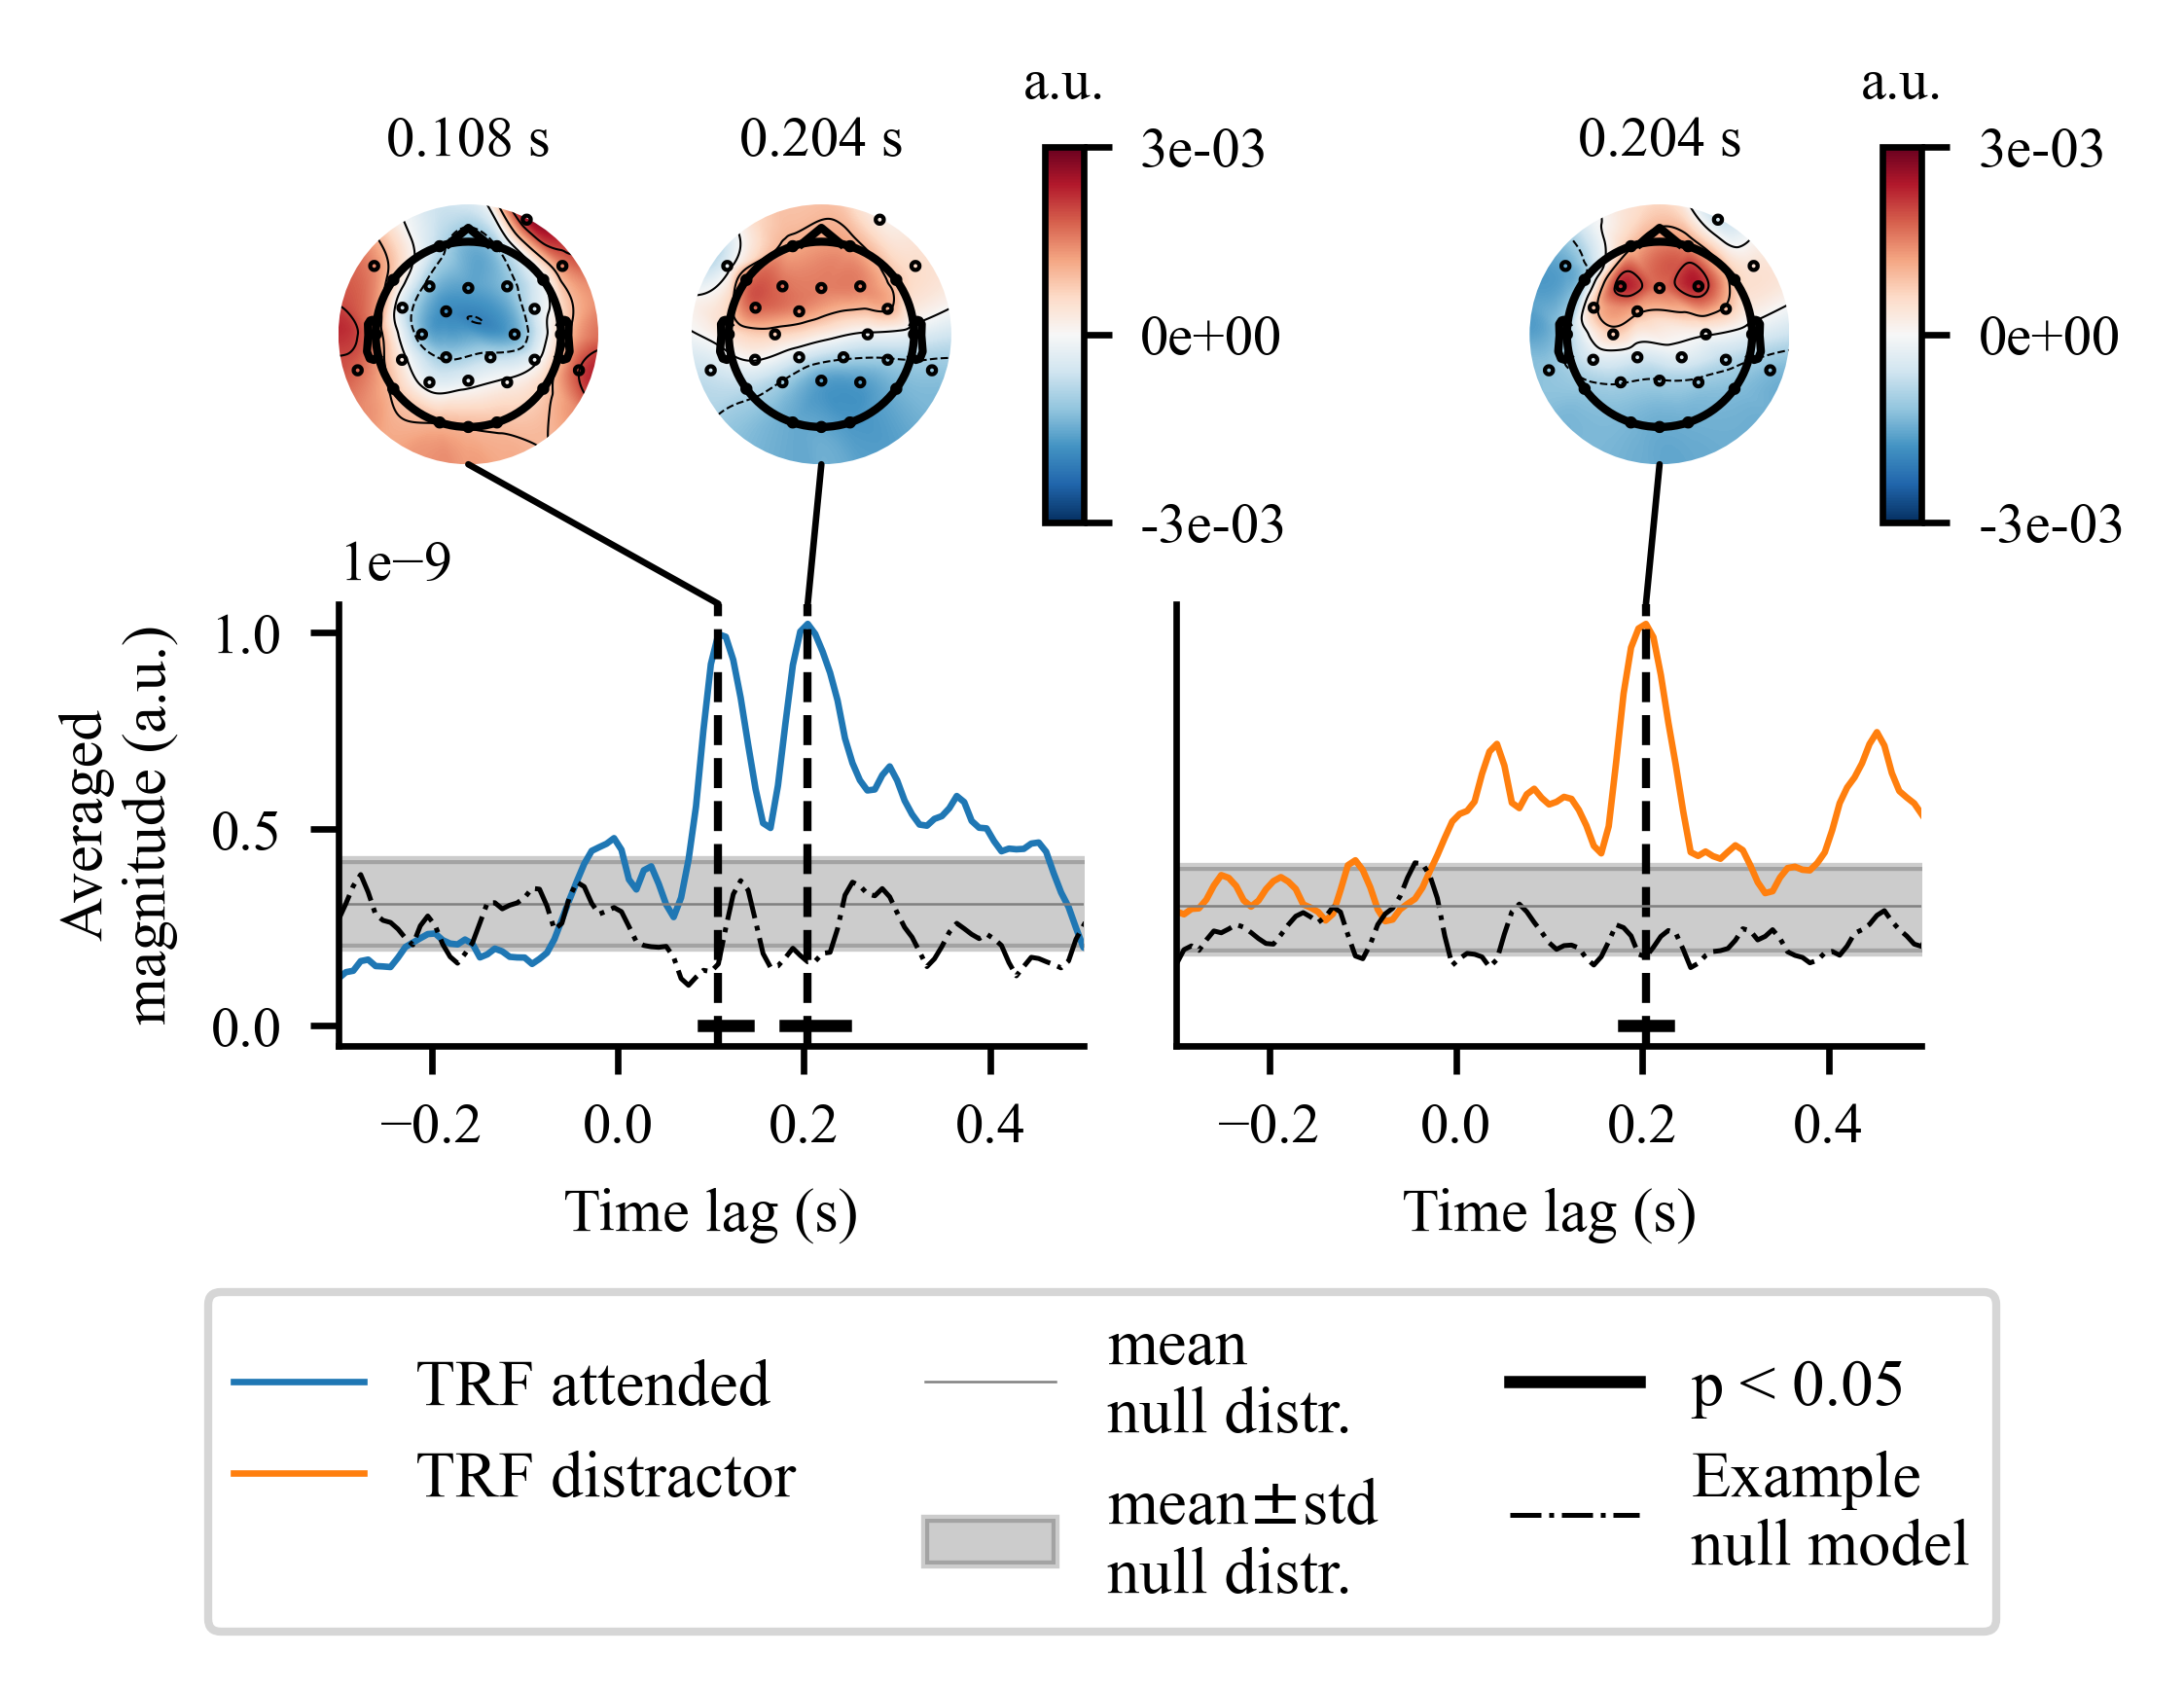

In [133]:
fig = plt.figure(figsize=(3.5, 2.0), dpi=600, layout='compressed')
spec = fig.add_gridspec(2,6, width_ratios = [1, 1, 0.15, 1, 1, 0.15], height_ratios = [1.7, 2.0],wspace=0.5)
ax0, ax1, ax2, ax3, ax4, ax5 = fig.add_subplot(spec[0,0]), fig.add_subplot(spec[0,1]), fig.add_subplot(spec[0,2]), fig.add_subplot(spec[0,3]), fig.add_subplot(spec[0,4]), fig.add_subplot(spec[0,5])
ax1_0, ax2_0 = fig.add_subplot(spec[1,:3]), fig.add_subplot(spec[1,3:])
plot_topos(attended_evoked, [peak_0_att, peak_1_att], [ax0, ax1, ax2], 7, y_ticks= [-3e-3, 0, 3e-3])
plot_topos(distractor_evoked, peak_0_distr, [ax4,ax5], 7, y_ticks= [-3e-3, 0, 3e-3])
ax3.axis('off')
trf_att, trf_distr, null_model, null_distr, sig_bar = plot_mag_trfs(ax1_0, ax2_0, legend=2)
con = add_connection(ax1_0, ax0, peak_0_att)
fig.add_artist(con)
con = add_connection(ax1_0, ax1, peak_1_att)
fig.add_artist(con)
con = add_connection(ax2_0, ax4, peak_0_distr)
fig.add_artist(con)

ax1_0.set_xticks([-0.2, 0, 0.2, 0.4])
ax2_0.set_xticks([-0.2, 0, 0.2, 0.4])
ax2_0.set_yticks([])

format_axis(ax1_0, 0.8)
format_axis(ax2_0, 0.8)

handles_att, labels_att = ax1_0.get_legend_handles_labels()
handles_distr, labels_distr = ax2_0.get_legend_handles_labels()
handles_att.insert(1, handles_distr[0])
labels_att.insert(1, labels_distr[0])
plt.legend(handles = handles_att, labels = labels_att, fontsize = fontsize_legend+2.0, ncols=3, loc='lower center', bbox_to_anchor=(-0.1,-1.4))

#plt.tight_layout()
fig_title = 'Magn_TRF_Overview_Paper'
fig.savefig(os.path.join(base_dir, 'reports/figures/trfs', fig_title + '.png'), bbox_inches='tight', dpi=600)
fig.savefig(os.path.join(base_dir, 'reports/figures/trfs', fig_title + '.pdf'), bbox_inches='tight', dpi=600)
fig.savefig(os.path.join(base_dir, 'reports/figures/trfs', fig_title + '.svg'), bbox_inches='tight', dpi=600)